# import packages

In [1]:
#Import Pacakges
import pandas as pd
from sbmtm import sbmtm
import graph_tool.all as gt
import pickle
import numpy as np
import pylab as plt
import seaborn as sns
from datetime import datetime
from dateutil import parser
from collections import defaultdict
import scipy.stats as stats

In [2]:
def mcc_classification(mcc):
    if mcc < 1500:
        return 'Agricultural Services'
    elif mcc < 3000:
        return 'Contracted Services'
    elif mcc < 4800:
        return 'Travel'
    elif mcc < 5000:
        return 'Utility Services'
    elif mcc < 5600:
        return 'Retail Outlet Services'
    elif mcc < 5700:
        return 'Clothing Stores'
    elif mcc < 7300:
        return 'Miscellaneous Stores'
    elif mcc < 8000:
        return 'Business Services'
    elif mcc < 9000:
        return 'Professional Services and Membership Organizations'
    else:
        return 'Government Services'

In [3]:
filtered_data = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='Clean_Transfers')
mcc_dict = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='MCC_List', skiprows=10, usecols='A:B', names=['mcc_code', 'Description'])

### data cleaning

# deal with mcc that are classified into multiple categories (keep the main category)
tempdf = filtered_data.groupby('MCC_List')['externalParty.transactionCategory'].value_counts(ascending=False).reset_index()
tempdf = tempdf.drop_duplicates(subset=['MCC_List'], keep='first')
# remap the categories to the filtered_data
filtered_data['externalParty.transactionCategory'] = filtered_data['MCC_List'].map(tempdf.set_index('MCC_List')['externalParty.transactionCategory'])

# select transactions with amount > 10
filtered_data = filtered_data[filtered_data['amount.value'] > 10]
# select customers with more than 10 transactions
filtered_data = filtered_data[filtered_data['customerId'].map(filtered_data['customerId'].value_counts()) > 10]

# drop the customers with less than 5 unique MCCs, to better represent the customer's spending habits
filtered_data = filtered_data[filtered_data['customerId'].map(filtered_data.groupby('customerId')['MCC_List'].nunique()>4)]

# map the mcc_dict to the filtered_data and drop the rows with NaN MCC values
filtered_data['MCC_List'] = filtered_data['externalParty.merchantCategoryCode'].map(mcc_dict.set_index('mcc_code')['Description'])
filtered_data = filtered_data.dropna(subset=['MCC_List'])
# fill the missing carbon emission values with the calculated carbon emission values based on the emission rate of the MCC
# calculate the emission rate of each transaction
filtered_data['emission_rate'] = filtered_data.apply(lambda x: x['transactionFootPrint.carbonEmissionInGrams']/x['amount.value'] if x['amount.value']!=0 else 0, axis=1)
# find the emission rate of each MCC
df_emission_rate = filtered_data.groupby('MCC_List')['emission_rate'].max().sort_values(ascending=True).reset_index().set_index('MCC_List').fillna(0)
# calculate the carbon emission of each transaction where missing
filtered_data['transactionFootPrint.carbonEmissionInGrams'] = filtered_data.apply(lambda x: x['amount.value']*df_emission_rate.loc[x['MCC_List']], axis=1)
filtered_data['mcc_classification'] = filtered_data['externalParty.merchantCategoryCode'].apply(mcc_classification)

df = filtered_data 

# Create a dictionary to store MCC lists for each customer
customer_mcc_dict = {}

# Iterate through the dataframe
for _, row in df.iterrows():
    customer_id = row['customerId']
    mcc = row['MCC_List']

    # Check if the customer_id is already in the dictionary
    if customer_id in customer_mcc_dict:
        customer_mcc_dict[customer_id].append(mcc)
    else:
        customer_mcc_dict[customer_id] = [mcc]

In [4]:
proportion_matrix = filtered_data.groupby(['customerId','MCC_List'])['amount.value'].sum().unstack().fillna(0).div(filtered_data.groupby('customerId')['amount.value'].sum(), axis=0).fillna(0)
proportion_matrix.head()

MCC_List,Advertising Services,Aer Lingus,Airlines and Air Carriers,"Airports, Flying Fields, and Airport Terminals","Amusement Parks, Circuses, Carnivals, and Fortune Tellers",Antique Shop,"Aquarium, Seaquarium, Dolphinariums",Art Dealers and Galleries,Artist Supply and Craft Stores,Automobile Associations,...,"Utilities-Electric, Gas, Water, and Sanitary",Variety Stores,Veterinary Services,Video Amusement Game Supply,Video Game Arcades and Establishments,"Watch, Clock, and Jewelry Repair Shops",Wholesale Club with or without membership fee,Wig & Toupee Shops,Women's Accessory and Specialty Stores,Women's Ready-to-Wear Stores
customerId,,,,,,,,,,,,,,,,,,,,,
01968de9-41cb-4509-b0a6-6bdc02700150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.005459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01b34ce5-ce43-4c2d-a73d-5294376bd399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.049722,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01b4698f-32be-4bc0-9b69-b3024ac18004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01ef943c-d661-48b0-9c0b-bb456a7d998d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
03025a2b-9179-4da9-8dff-af4a3179ce7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
connection_list = proportion_matrix.stack().reset_index()
connection_list.columns = ['customerId', 'MCC_List', 'connection']
connection_list = connection_list[connection_list['connection'] != 0]
connection_list.reset_index(drop=True, inplace=True)
connection_list

,customerId,MCC_List,connection
0,01968de9-41cb-4509-b0a6-6bdc02700150,Bakeries,0.002742
1,01968de9-41cb-4509-b0a6-6bdc02700150,Beauty and Barber Shops,0.010963
2,01968de9-41cb-4509-b0a6-6bdc02700150,"Bus Lines, includes Charters/Tour Buses",0.007739
3,01968de9-41cb-4509-b0a6-6bdc02700150,"Candy, Nut, and Confectionary Stores",0.001062
4,01968de9-41cb-4509-b0a6-6bdc02700150,Caterers - Prepare & Delivery,0.003133
...,...,...,...
4199,ffcf3506-a7d8-48a0-ba54-d4d54d15ee78,Shoe Stores,0.011356
4200,ffcf3506-a7d8-48a0-ba54-d4d54d15ee78,Sporting and Recreational Camps,0.003852
4201,ffcf3506-a7d8-48a0-ba54-d4d54d15ee78,"Stationery, Office and School Supply Stores",0.005890
4202,ffcf3506-a7d8-48a0-ba54-d4d54d15ee78,Tourist Attractions and Exhibits,0.000526


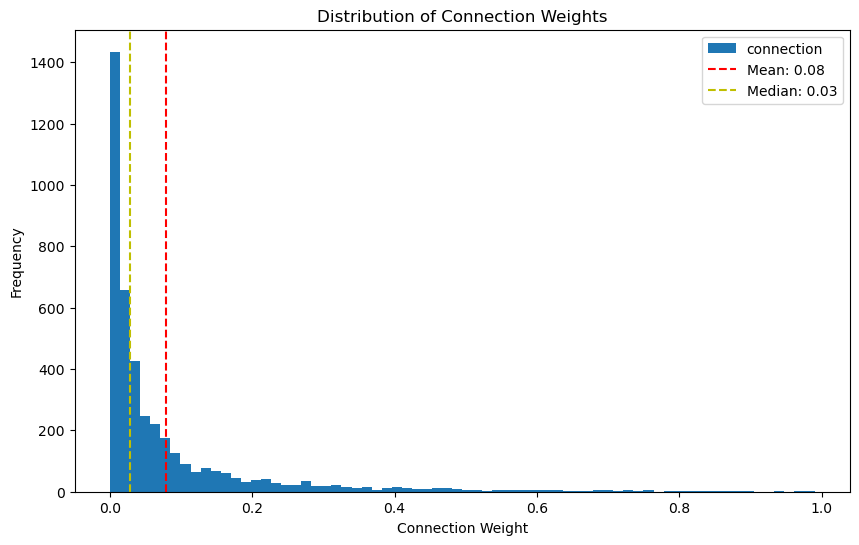

In [6]:
# plot the distribution of the connnection weights (proportion of mcc frequency)
data = connection_list['connection']
mean_value = np.mean(data)
median_value = np.median(data)
std_value = np.std(data)

plt.figure(figsize=(10, 6))
# sns.histplot(data, bins=50, kde=True)
data.plot(kind='hist', bins=70)
plt.axvline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='y', linestyle='--', label=f'Median: {median_value:.2f}')

plt.title('Distribution of Connection Weights')
plt.xlabel('Connection Weight')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [7]:
data = connection_list['connection']
print('Mean:', np.mean(data))
print('Median:', np.median(data))
print('Max:', np.max(data))
print('Min:', np.min(data))

Mean: 0.07921027592768792
Median: 0.028765792927482523
Max: 0.9901233153583674
Min: 0.00010104307544031463


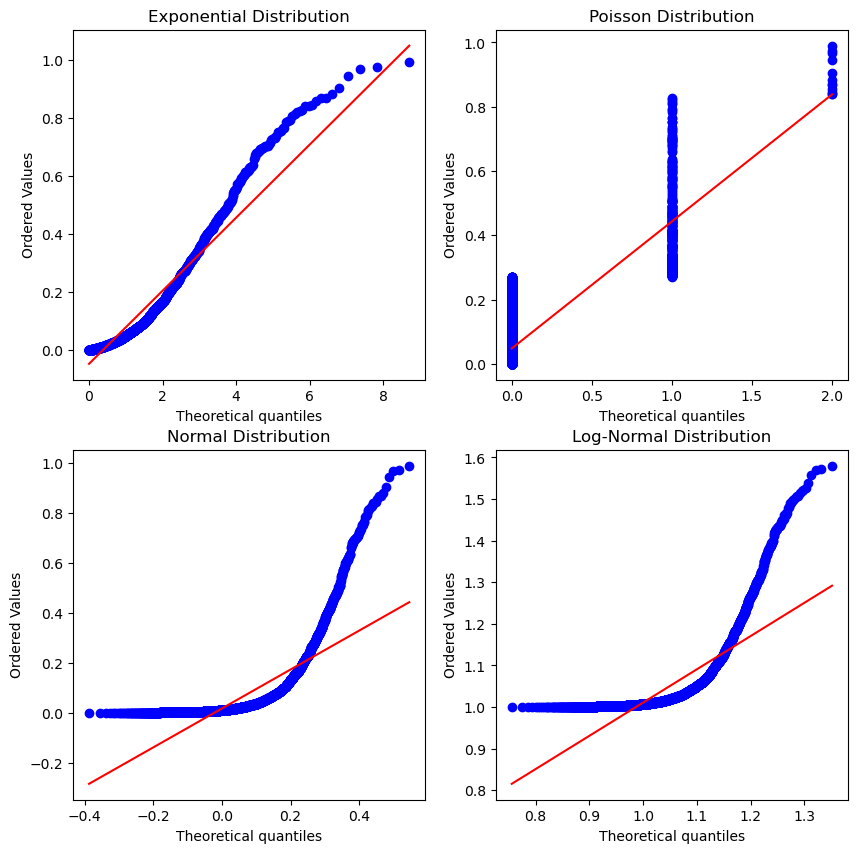

In [8]:
# plot the qq plot of frequency with the exponential distribution, normal distribution, and poisson distribution

# all plots in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

data = connection_list['connection']

# Exponential distribution
stats.probplot(data, dist="expon", plot=axs[0, 0])
axs[0, 0].set_title('Exponential Distribution')

# Poisson distribution
mu = data.mean()
stats.probplot(data, dist="poisson", sparams=(mu,), plot=axs[0, 1])
axs[0, 1].set_title('Poisson Distribution')

# Normal distribution
mu, std = stats.norm.fit(data)

stats.probplot(data, dist="norm", sparams=(mu, std), plot=axs[1, 0])
axs[1, 0].set_title('Normal Distribution')

# log-normal distribution
mu, std = stats.norm.fit(np.log2(data+2))
stats.probplot(np.log2(data+2), dist="norm", sparams=(mu, std), plot=axs[1, 1])
axs[1, 1].set_title('Log-Normal Distribution')
plt.show()

In [9]:
rng = np.random.default_rng(seed=41)

data = connection_list['connection']
stats.expon.fit(data)

(0.00010104307544031463, 0.07910923285224761)

cvm Statistics:  73.2972838810631 , p-value:  0.0001


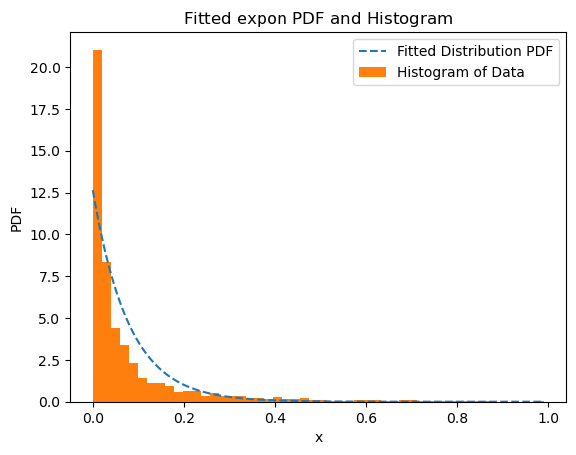

In [10]:
rng = np.random.default_rng(seed=41)

data = connection_list['connection']
loc, scale = stats.expon.fit(data)

known_params = {'loc': loc, 'scale': scale}
method = 'cvm'
# method = 'filliben'
# method = 'ad'
# method = 'ks'

res = stats.goodness_of_fit(stats.expon, data, known_params=known_params,
                            random_state=rng, statistic=method)
print("cvm Statistics: ", res.statistic, ", p-value: ", res.pvalue)
res.fit_result.plot()
plt.show()

# build a network

In [11]:
connection_list

,customerId,MCC_List,connection
0,01968de9-41cb-4509-b0a6-6bdc02700150,Bakeries,0.002742
1,01968de9-41cb-4509-b0a6-6bdc02700150,Beauty and Barber Shops,0.010963
2,01968de9-41cb-4509-b0a6-6bdc02700150,"Bus Lines, includes Charters/Tour Buses",0.007739
3,01968de9-41cb-4509-b0a6-6bdc02700150,"Candy, Nut, and Confectionary Stores",0.001062
4,01968de9-41cb-4509-b0a6-6bdc02700150,Caterers - Prepare & Delivery,0.003133
...,...,...,...
4199,ffcf3506-a7d8-48a0-ba54-d4d54d15ee78,Shoe Stores,0.011356
4200,ffcf3506-a7d8-48a0-ba54-d4d54d15ee78,Sporting and Recreational Camps,0.003852
4201,ffcf3506-a7d8-48a0-ba54-d4d54d15ee78,"Stationery, Office and School Supply Stores",0.005890
4202,ffcf3506-a7d8-48a0-ba54-d4d54d15ee78,Tourist Attractions and Exhibits,0.000526


In [12]:
# build a weighted network
g = gt.Graph(directed=False)
# difine the node properties
## name: docs - title, words - 'word'
## kind: docs(customers) - 0, words(mcc) - 1
name = g.vp['name'] = g.new_vp('string')
kind = g.vp['kind'] = g.new_vp('int')
## define the edge properties
weight = g.ep['weight'] = g.new_ep('double')

docs_add = defaultdict(lambda: g.add_vertex())
words_add = defaultdict(lambda: g.add_vertex())

for _, row in connection_list.iterrows():
    customer = row['customerId']
    mcc = row['MCC_List']
    weight = row['connection']
    # add customer node
    docs = docs_add[customer]
    name[docs] = customer
    kind[docs] = 0
    # add mcc node
    words = words_add[mcc]
    name[words] = mcc
    kind[words] = 1
    edge = g.edge(docs, words)
    if edge is None:
        edge = g.add_edge(docs, words)
        g.ep['weight'][edge] = 0
    g.ep['weight'][edge] += weight

# Nested SBM

In [13]:
SEED = 41
gt.seed_rng(SEED)

n_init = 2
clabel = g.vp['kind']

state_args = {'clabel': clabel
              , 'pclabel': clabel
              # , 'eweight': g.ep['weight']
              , 'recs':[g.ep['weight']]
              , 'rec_types': ['real-exponential']
            #   , 'rec_types': ['real-normal']
              }

mdl = np.inf
for i_n_init in range(n_init):
    base_type = gt.BlockState
    state_tmp = gt.minimize_nested_blockmodel_dl(g
                                                 ,state_args=dict(base_type=base_type,**state_args)
                                                 ,multilevel_mcmc_args=dict(niter=1, verbose=False)
                                                 )
    L = 0
    for s in state_tmp.levels:
        L += 1
        if s.get_nonempty_B() == 2:
            break
    state_tmp = state_tmp.copy(bs=state_tmp.get_bs()[:L] + [np.zeros(1)])
    print(state_tmp.entropy())

    mdl_tmp = state_tmp.entropy()
    if mdl_tmp < mdl:
        mdl = 1.0*mdl_tmp
        state = state_tmp.copy()

g.state = state
g.mdl = state.entropy()
L = len(state.levels)
if L == 2:
    g.L = 1
else:
    g.L = L-2

245.2415786477796
144.65260717163093


In [14]:
print('The lowest entropy was {}, and the state has {} blocks at level 1'.format(g.state.entropy(),g.state.get_levels()[1].get_nonempty_B()))

The lowest entropy was 144.65260717163093, and the state has 16 blocks at level 1


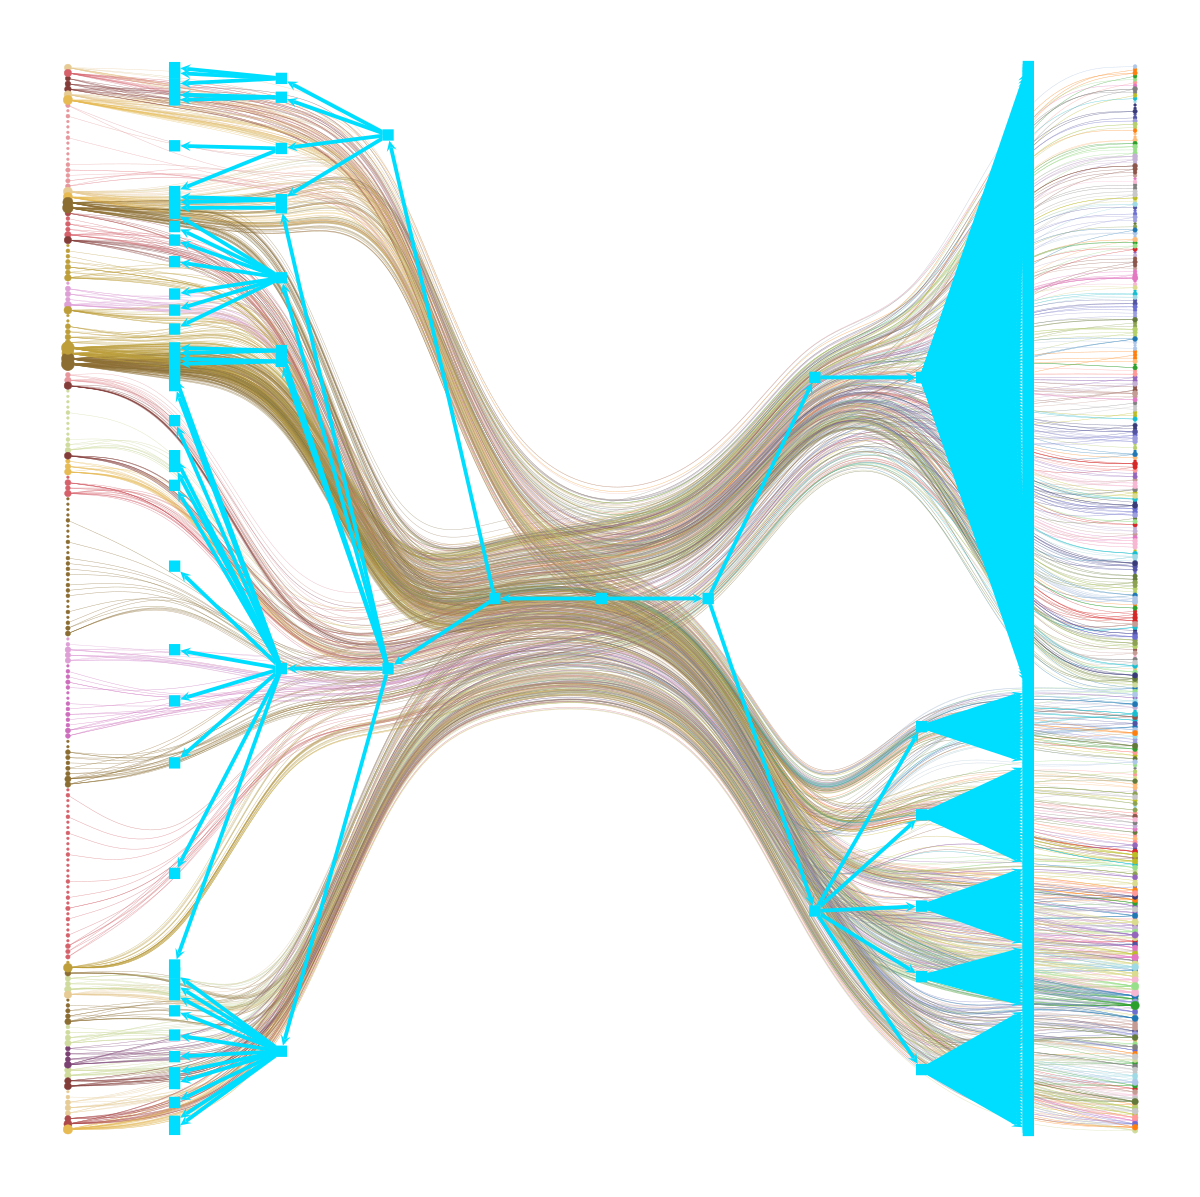

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f378ad53560, at 0x7f378ea062a0>,
 <GraphView object, directed, with 931 vertices and 930 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f378bba79b0, at 0x7f378baaddc0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f378bba79b0, at 0x7f378baacc80>, False), at 0x7f378bba79b0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f378bba79b0, at 0x7f378e8755e0>)

In [15]:
g.state.draw(subsample_edges=1000,layout='bipartite',bip_aspect=1,
           hvertex_size=8, hedge_pen_width=1.9, hedge_color="#00deff", hvertex_fill_color="#00DEFF", output_size=(600, 600))

In [16]:
state_l0 = g.state.project_level(0).copy()
state_l1 = g.state.project_level(1).copy()

In [17]:
b0 = gt.contiguous_map(state_l0.b)
b1 = gt.contiguous_map(state_l1.b)
label_map = {}
for v in g.vertices():
    label_map[state_l0.b[v]] = b0[v]
state_l0 = state_l0.copy(b=b0)
state_l1 = state_l1.copy(b=b1)

In [18]:
# create a dict for nodes and their blocks
blocks = {}
for v in g.vertices():
    blocks[name[v]] = [kind[v], state_l1.get_blocks()[v], state_l0.get_blocks()[v]]

In [19]:
df_clusters = pd.DataFrame.from_dict(blocks, orient='index', columns=['kind', 'level_1', 'level_0']).reset_index()
df_clusters = df_clusters.rename(columns={'index':'node'})
df_clusters['node'] = df_clusters['node'].astype(str)
df_clusters['levels'] = df_clusters['level_1'].astype(str) + '_' + df_clusters['level_0'].astype(str)
df_clusters.sort_values(by=['kind','level_1','level_0'], ascending=True, inplace=True)
df_clusters = df_clusters[df_clusters['kind'] == 0].reset_index(drop=True)
df_clusters.reset_index(drop=True, inplace=True)
df_clusters

,node,kind,level_1,level_0,levels
0,01968de9-41cb-4509-b0a6-6bdc02700150,0,0,0,0_0
1,2aa2a980-470d-470a-8379-ec51e5036ee4,0,0,93,0_93
2,3253926e-9c0d-4fd9-8248-eb7c2f457b99,0,0,99,0_99
3,40145ab5-241c-47c5-bb6a-3a05374b28a9,0,0,115,0_115
4,75152c18-f4aa-42e2-ad90-ad74beddd74c,0,0,183,0_183
...,...,...,...,...,...
328,e98858db-9929-4f28-adf9-b1c862a61556,0,15,342,15_342
329,ea822a61-a9fc-4fb2-9e6b-8b52ced5b3e5,0,15,347,15_347
330,eb6043b4-9a96-4552-95ac-8fc53a176e90,0,15,348,15_348
331,ec69f89b-b0ed-4bea-9092-1484b9139f64,0,15,349,15_349


In [20]:
df_clusters['level_0'].nunique()

333

In [330]:
df_clusters['levels'].unique()

array(['0_0', '0_33', '0_36', '0_42', '0_52', '0_54', '0_58', '0_66',
       '0_78', '0_79', '0_86', '8_22', '8_44', '8_47', '8_61', '8_63',
       '8_71', '8_74', '8_76', '8_77', '8_81', '8_82', '8_83', '8_85',
       '8_88', '8_89', '8_92', '9_26', '9_53', '9_67', '9_84', '10_28',
       '10_48', '10_51', '10_65', '10_75', '10_91', '11_37', '11_39',
       '11_40', '11_55', '11_57', '11_64', '11_68', '11_69', '11_70',
       '11_90', '13_56', '13_73', '13_80', '13_87'], dtype=object)

In [21]:
df_clusters[df_clusters['levels'] == '0_0']['node'].values

array(['01968de9-41cb-4509-b0a6-6bdc02700150'], dtype=object)

Block 0: 19
Block 10: 195
Block 12: 23
Block 13: 25
Block 14: 39
Block 15: 32


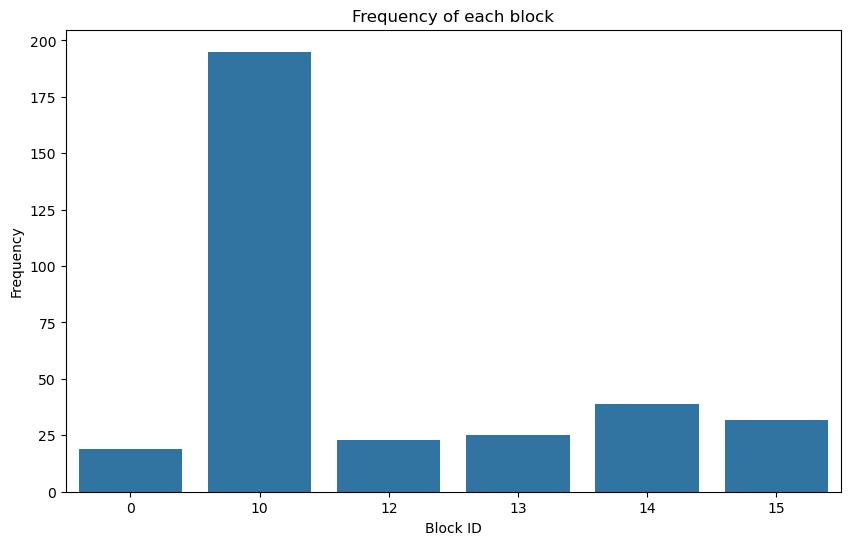

In [23]:
# calculate the frequency of each block and sort them by the id of the block
block_freq = {}
l=1
for i in df_clusters['level_{}'.format(l)].unique():
    # block_freq[str(i)] = len([x for x in b if x == i])
    block_freq[i] = len(df_clusters[df_clusters['level_{}'.format(l)] == i])
    print('Block {}: {}'.format(i, block_freq[i]))
# plot the frequency of each block
plt.figure(figsize=(10, 6))
sns.barplot(x=list(block_freq.keys()), y=list(block_freq.values()))
plt.xlabel('Block ID')
plt.ylabel('Frequency')
plt.title('Frequency of each block')
plt.show()

## Heatmaps of Purchases by Cluster

In [24]:
def heatmaps(df_clusters, df, yvalues=['MCC_List'], xvalues=['levels'], topn=False, relative=False, value='frequency', level_detail=False, max_label_len=False):
    '''
    df_clusters: DataFrame, the DataFrame with the cluster information
    df: DataFrame, the DataFrame with the transactions data
    yvalues: list, hierarchical levels to be used as y-axis values (categories)
    xvalues: list, hierarchical levels to be used as x-axis values (levels)
    topn: int, the number of top categories to be shown in the heatmap, valid only if yvalues has one level
    relative: bool, if True, the heatmap will show the relative frequency of the categories
    '''
    if len(yvalues) == 2:
        df['y'] = df[yvalues[0]] + '_' + df[yvalues[1]]
        annot = False
        ytick = False
    else:
        df['y'] = df[yvalues[0]]
        if len(xvalues) == 2:
            annot = False
        else:
            annot = True
        ytick = True
    # population average of the transactions frequency/amount for calculating the relative frequency
    if value == 'frequency':
        df_avg = df['y'].value_counts(normalize=True).reset_index().set_index('y')
        df['count'] = 1
    elif value == 'amount':
        df_avg = (df.groupby('y')['amount.value'].sum()/df['amount.value'].sum()).rename('proportion').reset_index().set_index('y')
        df['count'] = df['amount.value']

    # Get the normalized MCC transaction counts for each cluster
    cluster_counts = []
    for cluster in df_clusters[xvalues[-1]].unique():
        # Filter the DataFrame based on the customer IDs in the cluster
        custid = df_clusters[df_clusters[xvalues[-1]] == cluster]['node'].values
        filtered_df = df[df['customerId'].isin(custid)]
        if relative:
            # Calculate the normalized counts for each MCC category
            # counts = np.log(filtered_df[yvalues[-1]].value_counts(normalize=True) / df_avg['proportion']).rename(cluster)
            counts = np.log((filtered_df.groupby('y')['count'].sum()/filtered_df['count'].sum()) / df_avg['proportion']).rename(cluster)
        else:
            counts = (filtered_df.groupby('y')['count'].sum()/filtered_df['count'].sum()).rename(cluster)
        cluster_counts.append(counts)

    # Combine the normalized counts into a single DataFrame
    df_data = pd.concat(cluster_counts, axis=1, sort=True).fillna(0)
    # limit the length of the index
    if max_label_len:
        df_data.index = df_data.index.map(lambda x: x[:max_label_len]+'...' if len(x) > max_label_len else x)
        df_avg.index = df_avg.index.map(lambda x: x[:max_label_len]+'...' if len(x) > max_label_len else x)
    limit = np.max([np.abs(df_data.min().min()), df_data.max().max()])

    # shows only the top mcc if topn is given
    if topn:
        # Get the top 10 categories with the highest average transaction percentages
        topn_index = df_avg.nlargest(topn, df_avg.keys()[0]).index
        # Filter the DataFrame to keep only the top categories
        df_data = df_data.loc[topn_index]

    # Create a heatmap
    plt.figure(figsize=(18, 10))
    if relative:
        sns.heatmap(df_data, cmap='PiYG', fmt='.2f', annot=annot, linewidths=.5, vmin=-limit, vmax=limit, yticklabels=ytick, xticklabels=level_detail)
    else:
        sns.heatmap(df_data, cmap='Reds', fmt='.2%', annot=annot, linewidths=.5, yticklabels=ytick, xticklabels=level_detail)
    if len(yvalues) == 2:
        for category, y in df.groupby(yvalues[0])['y'].nunique().sort_index().cumsum().items():
            plt.axhline(y=y, color='gray', lw=0.5, linestyle='--')
            plt.text(-1, y-0.5, category, ha='center', va='center', fontsize=8)
    if len(xvalues) == 2:
        y = len(df_data.index)
        for level, x in df_clusters.groupby(xvalues[0])[xvalues[1]].nunique().sort_index().cumsum().items():
            plt.axvline(x=x, color='black', lw=0.5, linestyle='--', alpha=0.7)
            if level_detail == False:
                plt.text(x-0.5, y*1.01, level, ha='center', va='center', fontsize=8)
    plt.title('Normalized MCC Categories Heatmap')
    plt.show()

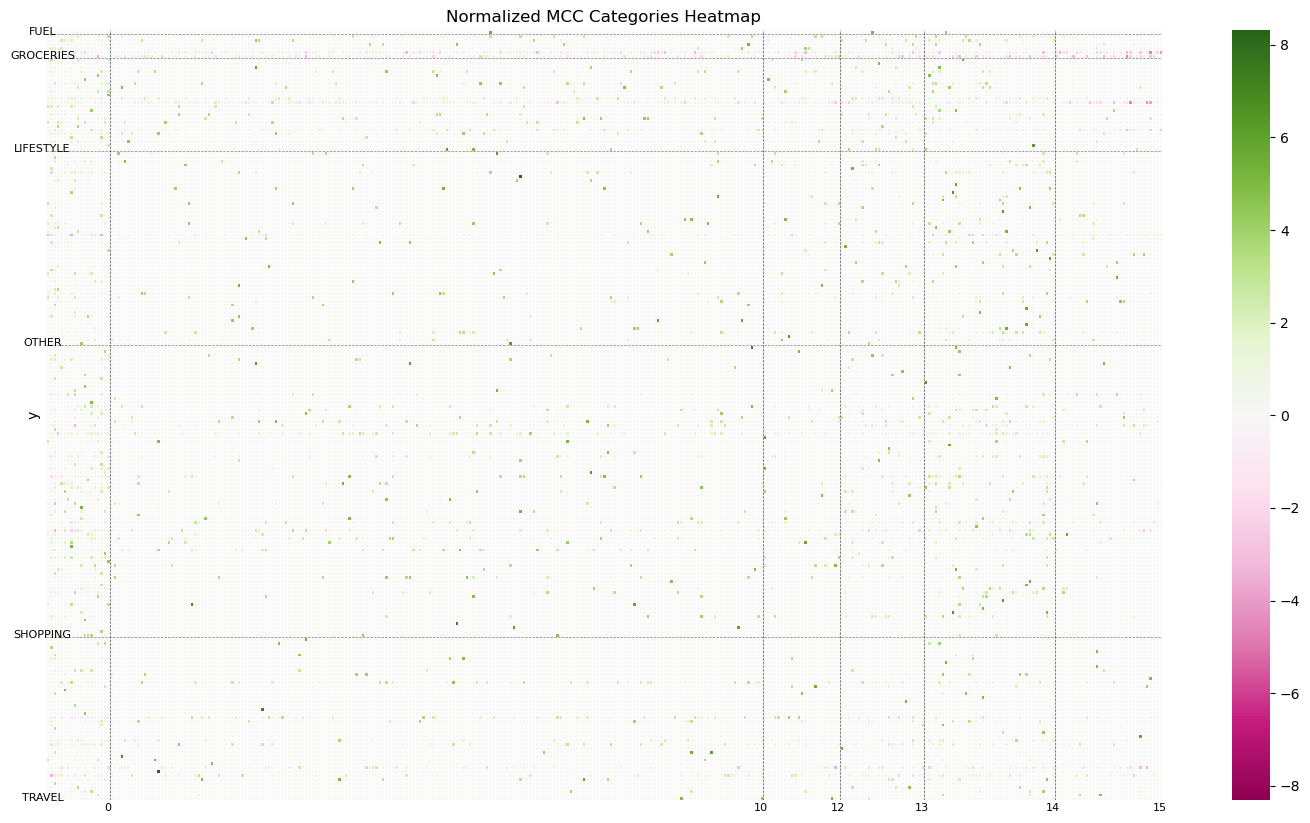

In [25]:
heatmaps(df_clusters, filtered_data, relative=True, yvalues=['externalParty.transactionCategory','MCC_List'], xvalues=['level_1','levels'], level_detail=False, value='amount')

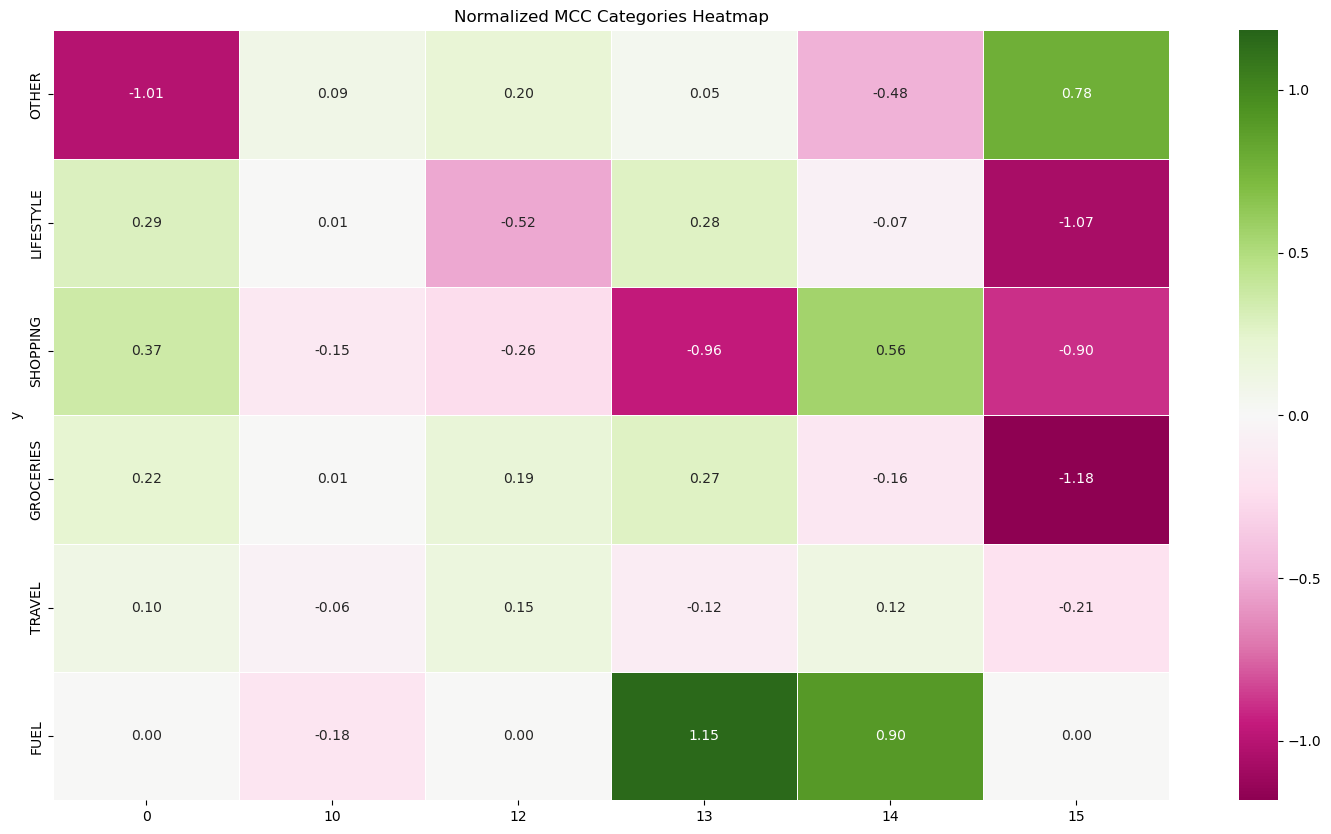

In [30]:
heatmaps(df_clusters, filtered_data, relative=True, yvalues=['externalParty.transactionCategory'], xvalues=['level_1'], level_detail=True, value='amount', topn=6)

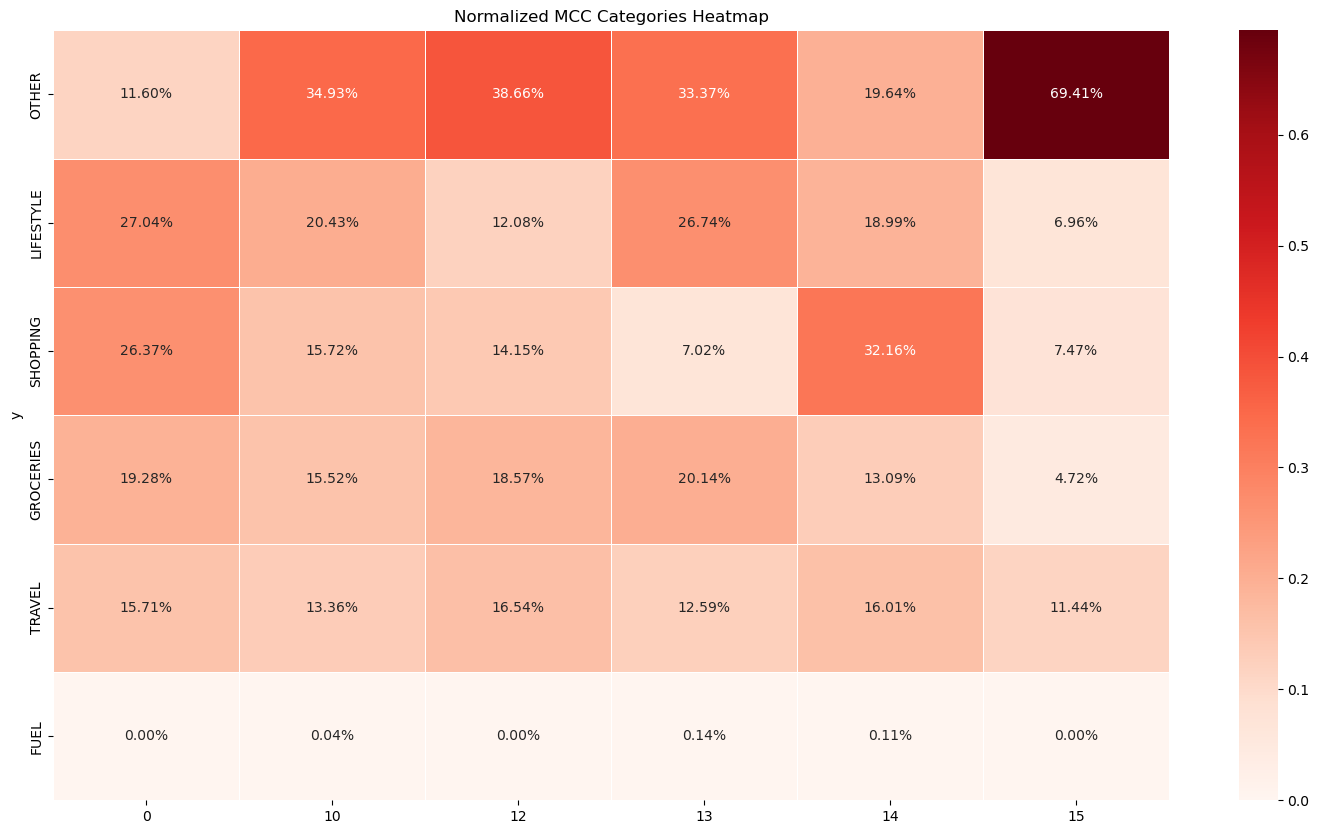

In [33]:
heatmaps(df_clusters, filtered_data, relative=False, yvalues=['externalParty.transactionCategory'], xvalues=['level_1'], level_detail=True, value='amount', topn=6)

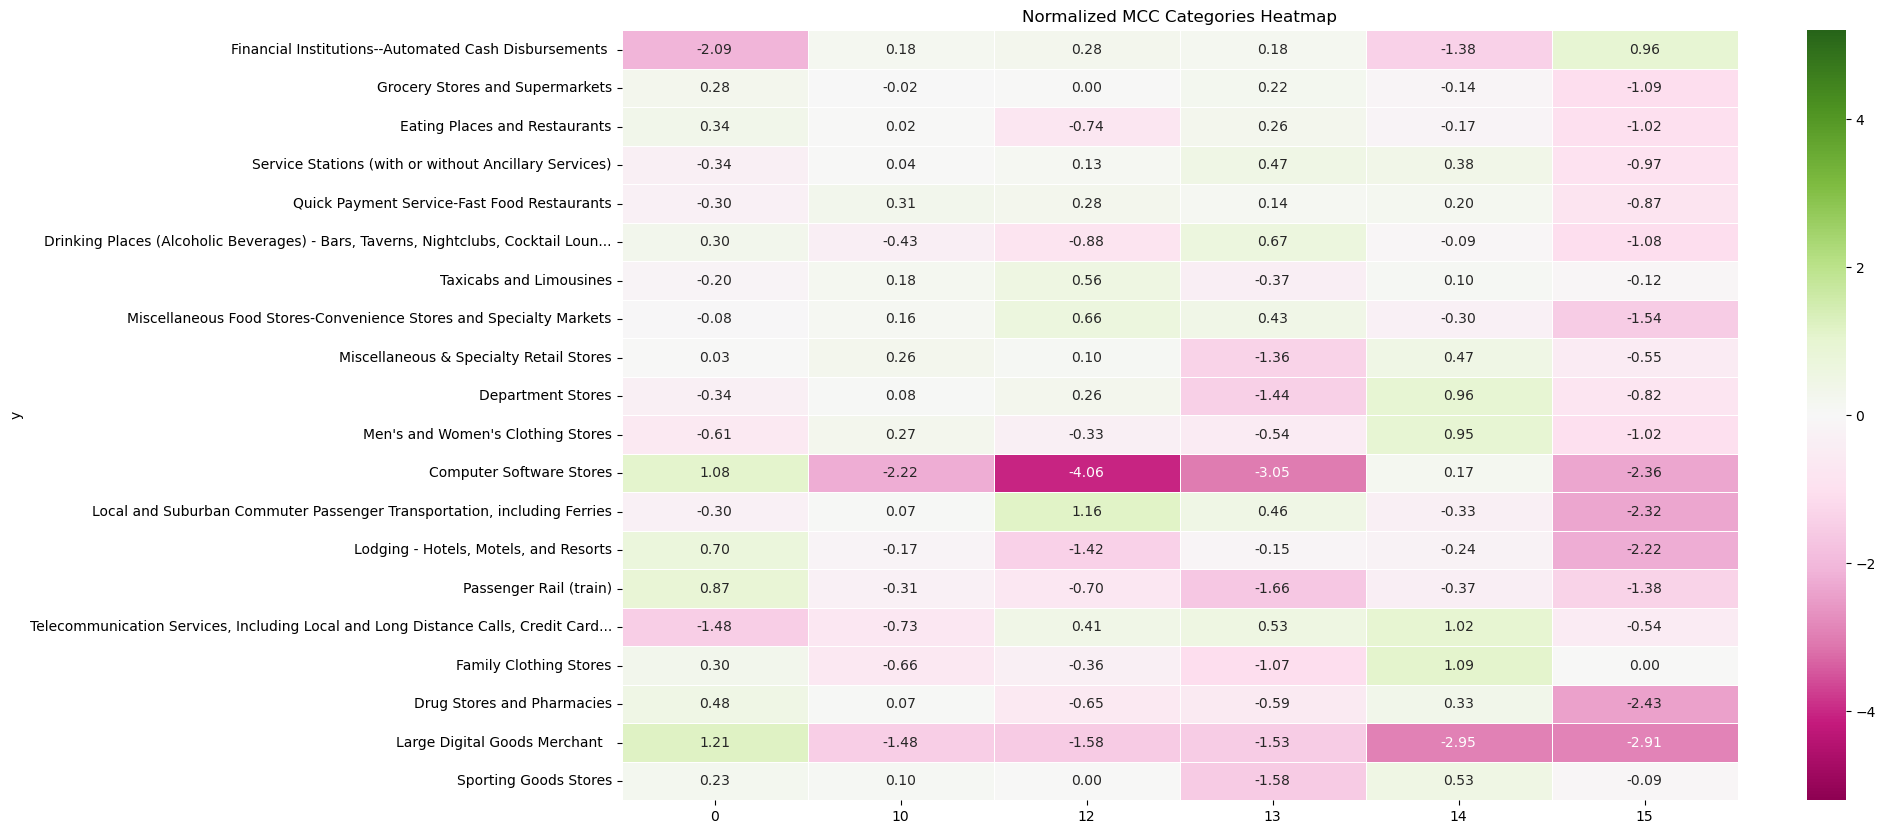

In [35]:
heatmaps(df_clusters, filtered_data, relative=True, yvalues=['MCC_List'], xvalues=['level_1'], level_detail=True, value='amount', topn=20, max_label_len=80)

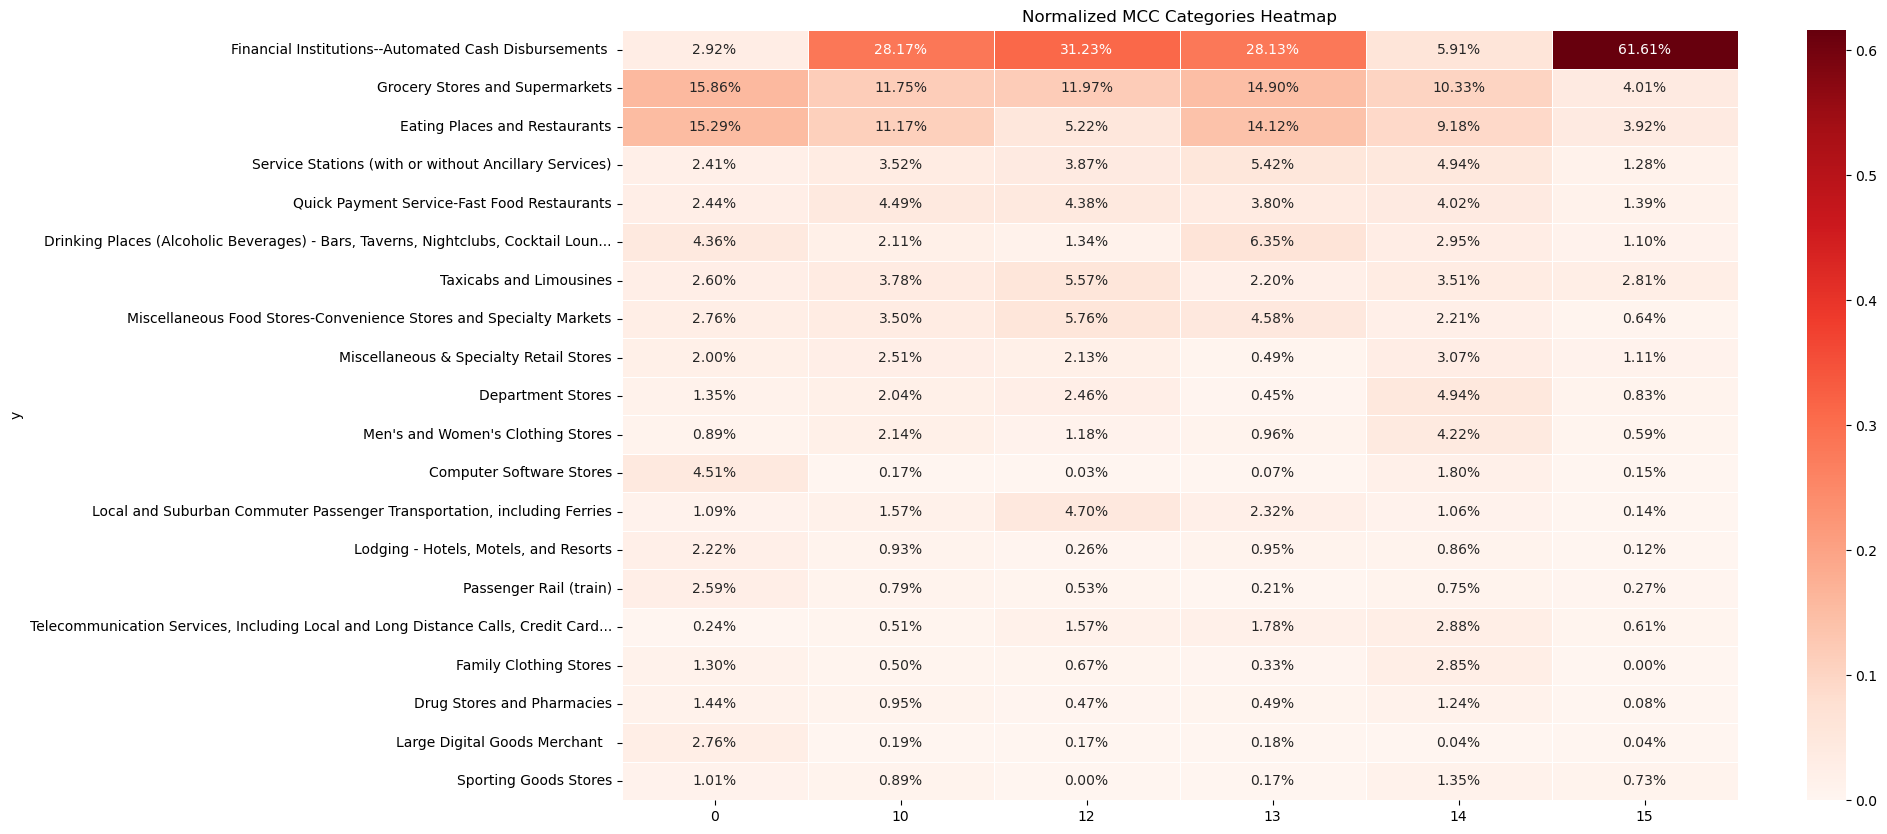

In [36]:
heatmaps(df_clusters, filtered_data, relative=False, yvalues=['MCC_List'], xvalues=['level_1'], level_detail=True, value='amount', topn=20, max_label_len=80)

# clustering result analysis